# MNIST Analysis

In [43]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve,
    roc_curve, roc_auc_score
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Download the dataset

In [2]:
mnist = fetch_openml('mnist_784', parser='auto')

## Exploratory analysis

In [3]:
mnist_keys = mnist.keys()
print(f'MNIST keys: {mnist_keys}')

MNIST keys: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [4]:
X, y = mnist['data'].values, mnist['target'].astype(np.uint8)
print(X.shape, y.shape)

(70000, 784) (70000,)


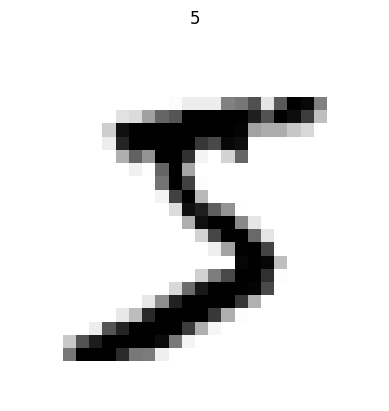

In [5]:
digit = X[0]
digit_image = digit.reshape(28, 28)
plt.imshow(digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.title(y[0])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## Training models

### Binary classifier

In [7]:
y_train_5 = (y_train == 5)

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)
sample_prediction = sgd_classifier.predict([digit])
print(sample_prediction)

[ True]


In [8]:
skfolds = StratifiedKFold(n_splits=3)

for train_indexes, test_indexes in skfolds.split(X_train, y_train_5):
    clone_sgd_classifier = clone(sgd_classifier)
    X_train_folds = X_train[train_indexes]
    y_train_folds = y_train_5[train_indexes]
    X_test_fold = X_train[test_indexes]
    y_test_fold = y_train_5[test_indexes]

    clone_sgd_classifier.fit(X_train_folds, y_train_folds)
    y_predicted = clone_sgd_classifier.predict(X_test_fold)
    correct_predictions = sum(y_predicted == y_test_fold)
    print(correct_predictions / len(y_predicted))

0.95035
0.96035
0.9604


In [9]:
cross_validation_score = cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')
print(cross_validation_score)

[0.95035 0.96035 0.9604 ]


In [10]:
y_train_predicted = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)
print(y_train_predicted)

[ True False False ...  True False False]


In [11]:
confusion_matrix = confusion_matrix(y_train_5, y_train_predicted)
print(confusion_matrix)

[[53892   687]
 [ 1891  3530]]


In [12]:
precision = precision_score(y_pred=y_train_predicted, y_true=y_train_5)
recall = recall_score(y_pred=y_train_predicted, y_true=y_train_5)
f1 = f1_score(y_pred=y_train_predicted, y_true=y_train_5)
print(f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}')

Precision: 0.8370879772350012 Recall: 0.6511713705958311 F1: 0.7325171197343846


In [13]:
threshold = 0

y_scores = sgd_classifier.decision_function([digit])
print(f'Classifier scores: {y_scores}')
y_digit_image_prediction = (y_scores > threshold)
print(f'Predictions: {y_digit_image_prediction}')

Classifier scores: [2164.22030239]
Predictions: [ True]


In [15]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

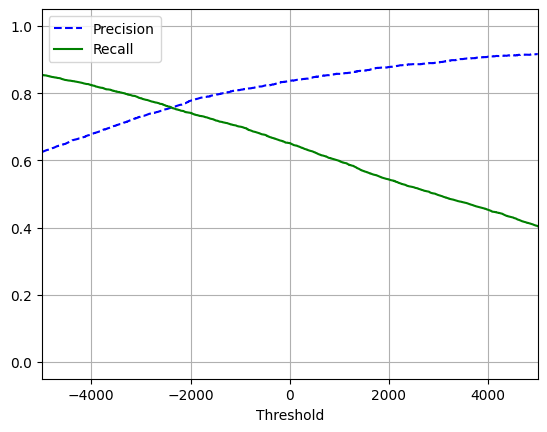

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.grid()
    plt.xlim(-5000, 5000)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

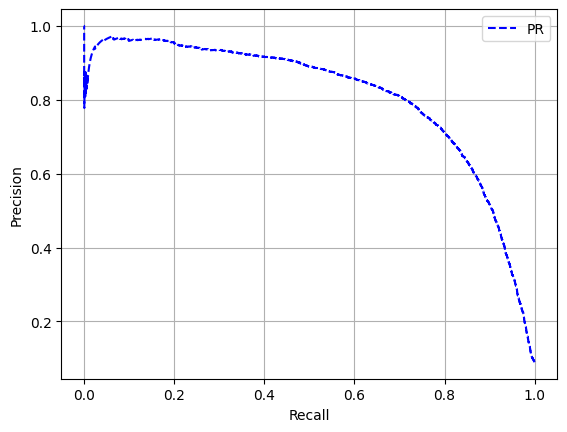

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'b--', label='PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)

3370.0194991439557


In [33]:
y_train_predicted_90 = y_scores >= threshold_90_precision
print(f'Precision: {precision_score(y_train_5, y_train_predicted_90)}')
print(f'Recall: {recall_score(y_train_5, y_train_predicted_90)}')

Precision: 0.9000345901072293
Recall: 0.4799852425751706


In [37]:
false_positive_rates, true_positive_rates, thresholds = roc_curve(y_train_5, y_scores)

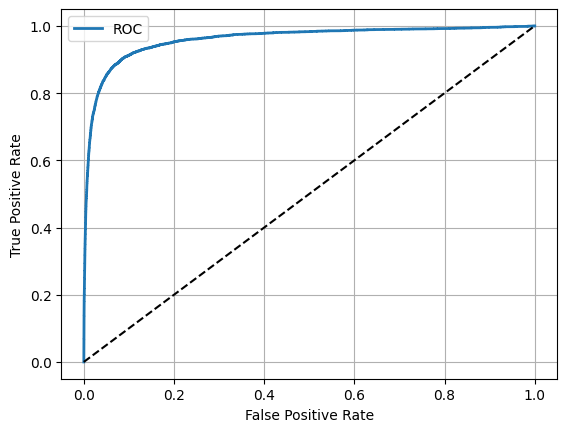

In [42]:
def plot_roc_curve(false_positive_rates, true_positive_rates, thresholds):
    plt.plot(false_positive_rates, true_positive_rates, linewidth=2, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()

plot_roc_curve(false_positive_rates, true_positive_rates, thresholds)
plt.show()

In [45]:
print(f'ROC AUC Score: {roc_auc_score(y_train_5, y_scores)}')

ROC AUC Score: 0.9604938554008616
